# Quickstart
This package tries to mimic the interface of [sklearn](https://scikit-learn.org/stable/) for easier use and compatibility.

Here is a minimal example to understand how the library works. In this example we try to make the model learn to transform the string "x" into "y".
The `.score` functions compute the [Character Error Rate (CER)](https://huggingface.co/spaces/evaluate-metric/cer), the lower, the better.

In [1]:
import sys

sys.path.append("paper-ner-bench-das22/src/ocr")  # XXX: Change ME

In [ ]:
import pandas as pd

from src.controller import InsertDeletionController, LengthController
from src.error_detector import ErrorDetector
from src.NMT_corrector import NMTCorrector
from src.pipeline import Pipeline

x = pd.Series(["x"] * 100)
y = pd.Series(["y"] * 100)

pipeline = Pipeline(
    error_detector=ErrorDetector(),
    nmt_corrector=NMTCorrector(train_steps=10),
    controller=InsertDeletionController(),
)

pipeline.fit(x, y)
pipeline.score(x, y)  # 0 of CER

In [ ]:
# Predict "y"
pipeline.predict(pd.Series(["x"]))

## Test 50/50 split against 90/10
A 50/50 split would be relevant in order to have a more significant test set.
Otherwise, a more classic 90/10 split would consitutes a test set of around a thousand elements, which makes 1% difference in performance less significant.

In [1]:
from pathlib import Path

import pandas as pd
from evaluate import load  # Hugging Face
from sklearn.model_selection import train_test_split

from src.controller import LengthController
from src.error_detector import ErrorDetector
from src.NMT_corrector import NMTCorrector
from src.pipeline import Pipeline


def json_file_to_df(path: str) -> pd.DataFrame:
    with open(path, "r") as json_file:
        return pd.read_json(json_file)


def get_df(human_annot_path: Path, extracted_data_path: Path) -> pd.DataFrame:
    human_df = json_file_to_df(human_annot_path)
    auto_df = json_file_to_df(extracted_data_path)

    df = human_df.loc[:, ["id", "book", "page", "text_ocr", "ner_xml"]]
    df = df.rename(columns={"text_ocr": "Ground Truth"})
    df.loc[:, "Sample"] = auto_df.loc[:, "text_ocr"]
    df.loc[:, "has_valid_ner_xml"] = auto_df.loc[:, "has_valid_ner_xml"]

    return df

2023-06-01 12:59:09.844349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2023-06-01 12:59:09.844372: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
SEED = 42
extracted_data_path = Path("data/31-all_entries_ner_align_pero.json")
human_annot_path = Path("data/10-all_entries_ocr_ner_human.json")

df = get_df(human_annot_path, extracted_data_path)

train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    shuffle=True,
    random_state=SEED,
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

pipeline = Pipeline(
    error_detector=ErrorDetector(no_cuda=True),
    nmt_corrector=NMTCorrector(),
    controller=LengthController(),
)

pipeline.fit(train_df["Sample"], train_df["Ground Truth"])
ref_score = pipeline.score(test_df["Sample"], test_df["Ground Truth"])

In [ ]:
print("Reference correction score", ref_score)

In [5]:
cer = load("character")
uncorrected_score = cer.compute(
    predictions=test_df["Sample"], references=test_df["Ground Truth"]
)["cer_score"]

In [6]:
print("Raw uncorrected score", uncorrected_score)

Raw uncorrected score 0.03994435131206477


In [14]:
train_size = 0.7
reduced_train_df = train_df.loc[: int(train_size / 0.9 * len(train_df)), :]

reduced_pipeline = Pipeline(
    error_detector=ErrorDetector(no_cuda=True),
    nmt_corrector=NMTCorrector(),
    controller=LengthController(),
)

reduced_pipeline.fit(reduced_train_df["Sample"], reduced_train_df["Ground Truth"])
reduced_score = reduced_pipeline.score(test_df["Sample"], test_df["Ground Truth"])

In [ ]:
# Expect something close to: '0.033' (or at least below the uncorrected: '0.042')
print(reduced_score)

## Ablation study

In [ ]:
from copy import deepcopy

components = {
    "error_detector": pipeline.error_detector,
    "nmt_corrector": pipeline.nmt_corrector,
    "controller": pipeline.controller,
}

disabling_configurations = [
    None,
    "error_detector",
    "controller",
    ["error_detector", "controller"],
]


def disable_component(component_name):
    if component_name is None:
        return Pipeline(**components)

    new_components = deepcopy(components)
    new_components[component_name] = None
    new_pipeline = Pipeline(**new_components)
    return new_pipeline


ablation_results = {}
for components_to_disable in disabling_configurations:
    pipeline = disable_component(components_to_disable)
    predictions = pipeline.predict(test_df["Sample"])
    ablation_results[components_to_disable] = predictions

df = pd.DataFrame(ablation_results, index=test_df.index)
df.to_json("all_df.json")
df

## ICDAR2019 dataset
Test approach on another dataset: ICDAR2019.

More information on this dataset can found [here](https://sites.google.com/view/icdar2019-postcorrectionocr/dataset?authuser=0).

In [2]:
from src.icdar_utils import get_df

root_icdar_path = Path("data/icdar_dataset")
train_path = (
    root_icdar_path / "ICDAR2019_POCR_competition_training_18M_without_Finnish/FR"
)
test_path = (
    root_icdar_path / "ICDAR2019_POCR_competition_evaluation_4M_without_Finnish/FR"
)

train_df = get_df(train_path, align_input=True, filter_aligned_error=True)
test_df = get_df(test_path, align_input=True, filter_aligned_error=True)

In [3]:
train_df

,Sample,Ground Truth
0,4 #» Clttf CRF-CITY LA ROCHELLE 33 RUE DE LA S...,@@@@@@@@@@@CRF-CITY LA ROCHELLE 33 RUE DE LA S...
1,TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE - ...,TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE – ...
2,"<*» cittj CRF-C@HY LA ROCHELLE ^ 33 RUE DE ,A ...",@@@@ci@ty CRF-CITY LA ROCHELLE@@ 33 RUE DE LA ...
3,<#» City CRF-CITY LA ROCHELLE 33 RUE DE LA SCI...,@@@@city CRF-CITY LA ROCHELLE 33 RUE DE LA SCI...
4,Ni mi: 7075 Sor ie:@@@@@@@@@@01@ 1@@@@@@7 @@1@...,N@um@: 2025 Ser@ie:01 12-10-2016 12:52:49 (V1)...
...,...,...
1878,"Philippes, etc. Savoir fai@@@s à @ouz@ presens...","Philippes, etc. Savoir faisons à touz, presens..."
1879,"Johannes, Dei gratia Francorum rex. Notum faci...","Johannes, Dei gracia Francorum rex. Notum faci..."
1880,"Loys, etc., au seneschal de Poictou ou à son l...","Loys, etc., au seneschal de Poictou ou à son l..."
1881,"Charles, etc. Savoir faisons à touz, presens e...","Charles, etc. Savoir faisons à touz, presens e..."


In [ ]:
cer.compute(predictions=test_df["Sample"], references=test_df["Ground Truth"])

In [ ]:
micro_cer = load("cer")
micro_cer.compute(predictions=test_df["Sample"], references=test_df["Ground Truth"])

In [20]:
len(test_df)

592

### How to split in sentence each (long-)sample of the dataset?

#### Solution1: use `nltk.sent_tokenize`.

It is a sentence tokenizer based on an unsupervised models to skip abbreviation words and other common sentence boundaries trap. It is more complex than a simple `.split` based on sentence separators (periods, question marks, exclamation marks...), but also more robust.

(array([7.095e+03, 2.312e+03, 1.598e+03, 8.280e+02, 5.530e+02, 3.280e+02,
        2.140e+02, 1.740e+02, 1.010e+02, 8.100e+01, 4.800e+01, 5.600e+01,
        2.400e+01, 2.300e+01, 1.800e+01, 1.100e+01, 6.000e+00, 7.000e+00,
        7.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 0.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.41140e+02, 2.81280e+02, 4.21420e+02, 5.61560e+02,
        7.01700e+02, 8.41840e+02, 9.81980e+02, 1.12212e+03, 1.26226e+03,
        1.40240e+03, 1.54254e+03, 1.68268e+03, 1.82282e+03, 1.96296e+03,
        2.10310e+03, 2.24324e+03, 2.38338e+03, 2.52352e+03, 2.66366e+03,
        2.80380e+03, 2.94394e+03, 3.08408e+03, 3.22422e+03, 3.36436e+03,
        3.5

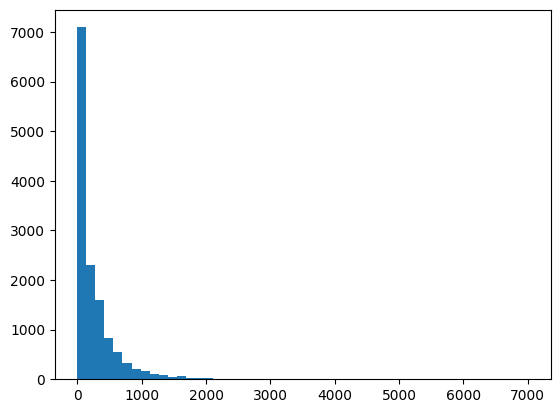

In [14]:
import matplotlib.pyplot as plt
import numpy as np


def get_len(str_):
    if len(str_) == 0:
        return ""

    sentences = sent_tokenize(str_.replace("@", ""), language="french")
    return list(map(len, sentences))


l = []
for str_ in train_df.loc[:, "Ground Truth"]:
    l.extend(get_len(str_))

plt.hist(l, bins=50)

In [12]:
from nltk import sent_tokenize

test_input = train_df.loc[2256, "Sample"]
test_output = train_df.loc[2256, "Ground Truth"]
sent_tokenize(test_output, language="french")

['Charles, etc.',
 'Savoir faisons à touz, presens et avenir, à nous avoir esté signifié par Colin de Landelles, demourant à Charros, ou païs de Poitou, que, comme pour cause de ce que par noz ennemis il avoit esté prins pluseurs foiz@ et par pillars et autres mauvaises genz desrobez souventes foiz, dont il a esté et estoit tellement dommagiez qu’il en estoit devenuz à pouvreté, et par ainsi lui consideranz qu’il estoit en telle misere, par induction et admonition d’autrui, eust depuis xx un an ença empruntez iiii frans d’or pour mettre et convertir en marchandises, dont il avoit a coustumé soy entremettre, et se fust transporté ou païs d’Orenge et environ, pour emploier la dicte somme de iiiixx frans d’or et en avoir blans et autre monnoie, qui illec avoient cours, la quelle il apporta ou dit païs de Poitou et environ en nostre royaume, et d’icelle fist satisfacion et paie ment à ses crediteurs, aus quelx il estoit tenuz pour les diz iiiixx frans et autrement\xa0; et pour ce il ait es

In [34]:
mock_input = "haa. bcd. eff."
mock_aligned = "haa. bcd. eff."
mock_output = "@aa. bcd. e@f."

mock_input_list = ["haa.", "bcd.", "eff."]
mock_output_list = ["@aa.", "bcd.", "e@f."]

In [8]:
from itertools import accumulate

ALIGNMENT_CHAR = ["@", "#"]


def extract_from_len(sentences_len: [int], text: str) -> [str]:
    start_idx = accumulate(sentences_len)
    return (text[start:end] for (start, end) in zip([0] + list(start_idx), start_idx))


def add_alignment_len(sentences_len: [int], aligned_text: str) -> [int]:
    start_idx = 0
    len_idx = 0

    for text_idx, char in enumerate(aligned_text):
        print(char, text_idx, start_idx, len_idx)
        if text_idx >= start_idx + sentences_len[len_idx]:
            start_idx += sentences_len[len_idx]
            len_idx += 1

        if char in ALIGNMENT_CHAR:
            sentences_len[len_idx] += 1

    return sentences_len


def clean_alignment(sentence: str) -> str:
    for char in ALIGNMENT_CHAR:
        sentence = sentence.replace(char, "")

    return sentence


def extract_sentences(
    input_: str,
    input_aligned: str,
    output_aligned: str,
    *,
    language: str = "french",
) -> [str]:
    output = clean_alignment(output_aligned)
    output_sentences = sent_tokenize(output, language=language)

    sentences_len = list(map(len, output_sentences))
    sentences_len = add_alignment_len(sentences_len, output_aligned)
    print(list(sentences_len))  # 4, 4, 4
    output_aligned_sentences = extract_from_len(sentences_len, output_aligned)

    sentences_len = map(len, output_aligned_sentences)
    input_aligned_sentences = extract_from_len(sentences_len, input_aligned)

    input_sentences = list(map(clean_alignment, input_aligned_sentences))

    return input_sentences, list(output_aligned_sentences), output_sentences

In [4]:
extract_sentences(mock_input, mock_aligned, mock_output)  # mock_output_list

NameError: name 'mock_input' is not defined

#### Solution2: Simple chunking

In [5]:
def chunkify(sample: str, *, chunk_size: int = 200):
    return [
        sample[start : start + chunk_size]
        for start in range(0, len(sample), chunk_size)
    ]

In [6]:
train_df["chunked_sample"] = train_df["Sample"].apply(chunkify)
train_df["chunked_gt"] = train_df["Ground Truth"].apply(chunkify)
train_df

,Sample,Ground Truth,chunked_sample,chunked_gt
0,4 #» Clttf CRF-CITY LA ROCHELLE 33 RUE DE LA S...,@@@@@@@@@@@CRF-CITY LA ROCHELLE 33 RUE DE LA S...,[4 #» Clttf CRF-CITY LA ROCHELLE 33 RUE DE LA ...,[@@@@@@@@@@@CRF-CITY LA ROCHELLE 33 RUE DE LA ...
1,TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE - ...,TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE – ...,[TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE -...,[TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE –...
2,"<*» cittj CRF-C@HY LA ROCHELLE ^ 33 RUE DE ,A ...",@@@@ci@ty CRF-CITY LA ROCHELLE@@ 33 RUE DE LA ...,"[<*» cittj CRF-C@HY LA ROCHELLE ^ 33 RUE DE ,A...",[@@@@ci@ty CRF-CITY LA ROCHELLE@@ 33 RUE DE LA...
3,<#» City CRF-CITY LA ROCHELLE 33 RUE DE LA SCI...,@@@@city CRF-CITY LA ROCHELLE 33 RUE DE LA SCI...,[<#» City CRF-CITY LA ROCHELLE 33 RUE DE LA SC...,[@@@@city CRF-CITY LA ROCHELLE 33 RUE DE LA SC...
4,Ni mi: 7075 Sor ie:@@@@@@@@@@01@ 1@@@@@@7 @@1@...,N@um@: 2025 Ser@ie:01 12-10-2016 12:52:49 (V1)...,[Ni mi: 7075 Sor ie:@@@@@@@@@@01@ 1@@@@@@7 @@1...,[N@um@: 2025 Ser@ie:01 12-10-2016 12:52:49 (V1...
...,...,...,...,...
1878,"Philippes, etc. Savoir fai@@@s à @ouz@ presens...","Philippes, etc. Savoir faisons à touz, presens...","[Philippes, etc. Savoir fai@@@s à @ouz@ presen...","[Philippes, etc. Savoir faisons à touz, presen..."
1879,"Johannes, Dei gratia Francorum rex. Notum faci...","Johannes, Dei gracia Francorum rex. Notum faci...","[Johannes, Dei gratia Francorum rex. Notum fac...","[Johannes, Dei gracia Francorum rex. Notum fac..."
1880,"Loys, etc., au seneschal de Poictou ou à son l...","Loys, etc., au seneschal de Poictou ou à son l...","[Loys, etc., au seneschal de Poictou ou à son ...","[Loys, etc., au seneschal de Poictou ou à son ..."
1881,"Charles, etc. Savoir faisons à touz, presens e...","Charles, etc. Savoir faisons à touz, presens e...","[Charles, etc. Savoir faisons à touz, presens ...","[Charles, etc. Savoir faisons à touz, presens ..."


In [16]:
train_df = train_df.explode(["chunked_sample", "chunked_gt"])

In [19]:
train_df["Clean Sample"] = train_df["chunked_sample"].apply(clean_alignment)
train_df["Clean Ground Truth"] = train_df["chunked_gt"].apply(clean_alignment)
train_df

,Sample,Ground Truth,chunked_sample,chunked_gt,Clean Sample,Clean Ground Truth
0,4 #» Clttf CRF-CITY LA ROCHELLE 33 RUE DE LA S...,@@@@@@@@@@@CRF-CITY LA ROCHELLE 33 RUE DE LA S...,4 #» Clttf CRF-CITY LA ROCHELLE 33 RUE DE LA S...,@@@@@@@@@@@CRF-CITY LA ROCHELLE 33 RUE DE LA S...,4 » Clttf CRF-CITY LA ROCHELLE 33 RUE DE LA SC...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...
0,4 #» Clttf CRF-CITY LA ROCHELLE 33 RUE DE LA S...,@@@@@@@@@@@CRF-CITY LA ROCHELLE 33 RUE DE LA S...,Monnaie -1.77s 0005 002 000255 25/03/2017 18:...,Monnaie -1.77€ 0005 002 000255 25/03/2017 18:...,Monnaie -1.77s 0005 002 000255 25/03/2017 18:...,Monnaie -1.77€ 0005 002 000255 25/03/2017 18:...
1,TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE - ...,TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE – ...,TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE - ...,TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE – ...,TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE - ...,TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE – ...
1,TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE - ...,TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE – ...,"ANE BIST Offert PERRIER 3,90 RICARD 3.80 PINEA...",ANE BIST Offert PERRIER 3.90 RICARD 3.80 PINEA...,"ANE BIST Offert PERRIER 3,90 RICARD 3.80 PINEA...",ANE BIST Offert PERRIER 3.90 RICARD 3.80 PINEA...
1,TSEO BISTRO! DE LA MER 4 PLACE DE LA CHAINE - ...,TSEO BISTROT DE LA MER 4 PLACE DE LA CHAINE – ...,E SIRET 537 924 755 000 11 LA ROCHELL TVA INTR...,E SIRET 537 924 755 000 11 LA ROCHELL TVA INTR...,E SIRET 537 924 755 000 11 LA ROCHELL TVA INTR...,E SIRET 537 924 755 000 11 LA ROCHELL TVA INTR...
...,...,...,...,...,...,...
1882,"Charles, etc. Savoir faisons à touz, presens e...","Charles, etc. Savoir faisons à touz, presens e...",emettre. et se fust transporté ou païs d@oieng...,"emettre, et se fust transporté ou païs d’Oreng...",emettre. et se fust transporté ou païs doienge...,"emettre, et se fust transporté ou païs d’Oreng..."
1882,"Charles, etc. Savoir faisons à touz, presens e...","Charles, etc. Savoir faisons à touz, presens e...",aïs de Poitou et environ en nostre royaume@ et...,"aïs de Poitou et environ en nostre royaume, et...",aïs de Poitou et environ en nostre royaume et ...,"aïs de Poitou et environ en nostre royaume, et..."
1882,"Charles, etc. Savoir faisons à touz, presens e...","Charles, etc. Savoir faisons à touz, presens e...",é moult grandement@ priz et detenuz en prison ...,"é moult grandement, priz et detenuz en prison ...",é moult grandement priz et detenuz en prison p...,"é moult grandement, priz et detenuz en prison ..."
1882,"Charles, etc. Savoir faisons à touz, presens e...","Charles, etc. Savoir faisons à touz, presens e...",estre poursui et molesté par noz genz et offic...,estre poursui et molesté par noz genz et offic...,estre poursui et molesté par noz genz et offic...,estre poursui et molesté par noz genz et offic...


In [21]:
test_df["chunked_sample"] = test_df["Sample"].apply(chunkify)
test_df["chunked_gt"] = test_df["Ground Truth"].apply(chunkify)

test_df = test_df.explode(["chunked_sample", "chunked_gt"])

test_df["Clean Sample"] = test_df["chunked_sample"].apply(clean_alignment)
test_df["Clean Ground Truth"] = test_df["chunked_gt"].apply(clean_alignment)
test_df

,Sample,Ground Truth,chunked_sample,chunked_gt,Clean Sample,Clean Ground Truth
0,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...
0,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,"E 1.30€ 0.440kg x 2.95(/kg ""POMME CHANTECLERC ...",E 1.30€ 0.440kg x 2.95€/kg *POMME CHANTECLERC ...,"E 1.30€ 0.440kg x 2.95(/kg ""POMME CHANTECLERC ...",E 1.30€ 0.440kg x 2.95€/kg *POMME CHANTECLERC ...
0,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,### r## ## *■#« #*# ## 0### w* a# #m #h# *# #w...,@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@...,r *■« * 0 w* a m h * w a a w a a ** a ■ ■ ...,
0,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,CRF-CITY LA ROCHELLE 33 RUE DE LA SCIERIE 1700...,m wma a#a ma mm mm m m# #m CB EMV SANS CONTACT...,@@@@@@@@@@@@@@@@@@@@@@@@@@ CB EMV SANS CONTACT...,m wma aa ma mm mm m m m CB EMV SANS CONTACT EU...,CB EMV SANS CONTACT EUR 7.90€ 0006 004 000134...
1,@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@169 RUE DU LIN...,poivre rouge RESTAURANT & GRILL 169 RUE DU LIN...,@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@169 RUE DU LIN...,poivre rouge RESTAURANT & GRILL 169 RUE DU LIN...,169 RUE DU LINTEAU 16430 CHAMPNIERS TEL. : 05....,poivre rouge RESTAURANT & GRILL 169 RUE DU LIN...
...,...,...,...,...,...,...
493,"@ap@@positis et impetitis predictis, considera...","à propositis et impetitis predictis, considera...","appo@itis, occasione premissorum. Datum et sig...","appositis, occasione premissorum. Datum et sig...","appoitis, occasione premissorum. Datum et sigi...","appositis, occasione premissorum. Datum et sig..."
493,"@ap@@positis et impetitis predictis, considera...","à propositis et impetitis predictis, considera...",imo octavo constat constat de int@@li@ear@is@c...,imo octavo.Constat Constat de interlineariis c...,imo octavo constat constat de intliearisconobe...,imo octavo.Constat Constat de interlineariis c...
493,"@ap@@positis et impetitis predictis, considera...","à propositis et impetitis predictis, considera...",sunt declarata@ rata et grata habentos@ ea@ q...,"sunt declarata, rata et grata habentes, ea, q...",sunt declarata rata et grata habentos ea quat...,"sunt declarata, rata et grata habentes, ea, q..."
493,"@ap@@positis et impetitis predictis, considera...","à propositis et impetitis predictis, considera...",peciali@ serie presencium@ confirmamus. In cuj...,"peciali, serie presencium, confirmamus. In cuj...",peciali serie presencium confirmamus. In cujus...,"peciali, serie presencium, confirmamus. In cuj..."


In [24]:
train_df["original idx"] = train_df.index
test_df["original idx"] = test_df.index

train_df = train_df.reset_index()
test_df = test_df.reset_index()

### Training

In [ ]:
pipeline = Pipeline(
    error_detector=ErrorDetector(no_cuda=True),
    # error_detector=ErrorDetector(
    #     model_name="bert-base-multilingual-cased", no_cuda=True
    # ),
    nmt_corrector=NMTCorrector(),
    controller=LengthController(),
)

pipeline.fit(train_df["Clean Sample"], train_df["Clean Ground Truth"])
pipeline.score(test_df["Clean Sample"], test_df["Clean Ground Truth"])